In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pickle

# Created Data Exploration

In [4]:
with open('data/consecutive_games_df.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [ ]:
num_teams = data['row_team'].nunique()
print(f'We have {num_teams} different teams in the data.')

In [30]:
# I only took columns of row team (not rival)
row_team_cols = ['row_team_wins', 'row_team_draws', 'row_team_league_points', 'row_team_season_goals', 
                 'prev_goal_diff']
rating_cols = [col for col in data.columns if 'rating' in col and 'rival' not in col]

bet_cols = [col for col in data.columns if '_bet_' in col]

## Histograms

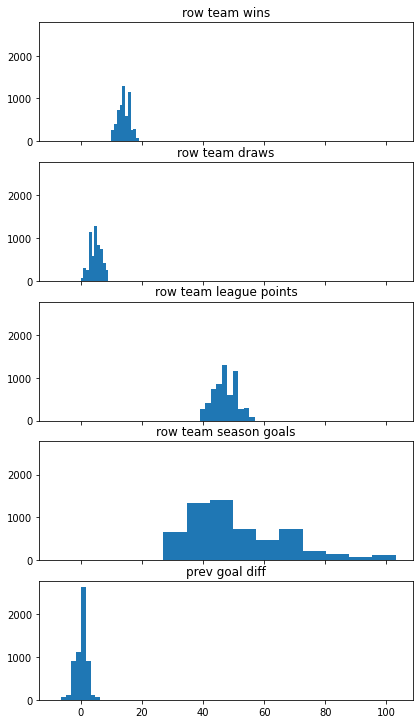

In [28]:
fig, axs = plt.subplots(len(row_team_cols), sharex=True, sharey=True)
fig.set_figheight(2 * len(row_team_cols))
plt.tight_layout()
for i, col in enumerate(row_team_cols):
    axs[i].hist(data[col])
    axs[i].set_title(col.replace('_', ' '))
plt.savefig('hist_row_team.png')

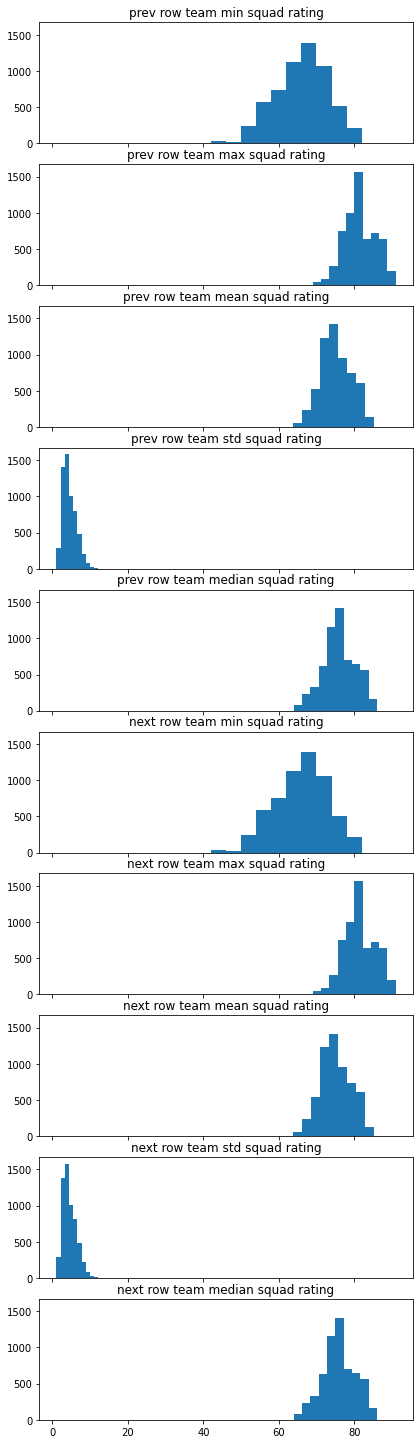

In [29]:
fig, axs = plt.subplots(len(rating_cols), sharex=True, sharey=True)
fig.set_figheight(2 * len(rating_cols))
plt.tight_layout()
for i, col in enumerate(rating_cols):
    axs[i].hist(data[col])
    axs[i].set_title(col.replace('_', ' '))
plt.savefig('hist_ratings.png')

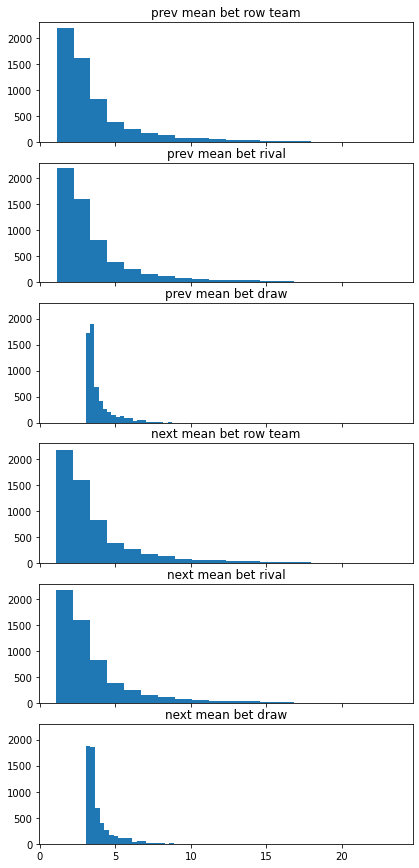

In [36]:
fig, axs = plt.subplots(len(bet_cols), sharex=True, sharey=True)
fig.set_figheight(2 * len(bet_cols))
plt.tight_layout()
for i, col in enumerate(bet_cols):
    axs[i].hist(data[col], bins=20)
    axs[i].set_title(col.replace('_', ' '))
plt.savefig('hist_bets.png')